# Geometric Gradient Descent

Gabriel Konar-Steenberg, 2022-10-25

## Problem Statement

Recall the problem from `conjugate_gradient_method.ipynb`:

"For a convex optimization problem with a cost function to minimize:
$$ f(x, y, z) = a(x-1)^4+(y-2)^2+b(z-1)^4 $$
choose your own parameter values $a > 0, b > 0$ and use $(2, 3, 2)$… as a start point for your iterations.… [W]rite… code for the conjugate gradient method, output a plot that illustrates a convergence toward the analytical result…."

(We chose $a=2, b=3$.) Now, we are asked to solve the same problem using the geometric gradient descent method from Sébastien Bubeck, "Convex Optimization, Algorithms and Complexity," Section 3.6.1.

## Solution

Adapting our solution for the previous homework, we define the parameters of the problem and some helper apparatus. For simplicity, we will begin with a ball of radius $R_0=4$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters of the problem
# n = 3  # dimensionality
a = 2
b = 3
x0 = np.array([[2], [3], [2]])
R0 = 4
B0 = (x0, R0**2)
answer = np.array([[1], [2], [1]])

def f(x):
    return (a*(x[0]-1)**4+(x[1]-2)**2+b*(x[2]-1)**4)

norm2 = np.linalg.norm  # Alias for the Euclidean norm

def grad_1d(pt, delta = 1e-6):  # Returns an approximation of the gradient of f at a given point
    xs = np.tile(pt, (*pt.shape, 1))  # Make n copies of x so we can perturb it in n dimensions
    xh = xs + np.eye(*xs.shape)*delta  # Perturb along each dimension
    return ((f(xh)-f(xs))/delta)  # Calculate the slope and reshape to taste  

def grad_col(pt, *args):  # grad_1d but accepts and returns column vectors
    return grad_1d(pt.T[0], *args).reshape(pt.shape)

def hess_1d(pt, delta_1 = 1e-6, delta_2 = 1e-5):  # Returns an approximation of the Hessian of f at a given point
    xs = np.tile(pt, (*pt.shape, 1))
    xh = xs + np.eye(*xs.shape)*delta_2
    # Presumably if I worked at it longer I could find an elegant way to do this without apply_along_axis
    initial = np.apply_along_axis(grad_1d, -1, xs, delta=delta_1)
    final = np.apply_along_axis(grad_1d, -1, xh, delta=delta_1)
    return (final-initial)/delta_2

def hess_col(pt, *args):  # hess_1d but accepts and returns column vectors
    return hess_1d(pt.T[0], *args).T

def normalize(vec):
    vec = np.array(vec, "float")
    vec_norm = norm2(vec)
    return vec if vec_norm == 0 else vec/vec_norm

# Maximum alpha for alpha-convexity is minimum eigenvalue of Hessian
# We need alpha-convexity in the neighborhood, not just at the point, so we add in a safety factor
# TODO: is there a better way to do this?
def max_alpha(x, safety=1.01):
    return np.min(np.linalg.eig(hess_col(x))[0])/safety

def min_beta(x, safety=1.01):  # Minimum beta for beta-smoothness is maximum eigenvalue of Hessian
    return np.max(np.linalg.eig(hess_col(x))[0])*safety

def get_kappa(x):  # Condition number = beta/alpha
    return min_beta(x)/max_alpha(x)

def get_x_plus(x):  # x^+
    return x-1/min_beta(x)*grad_col(x)

def get_x_plus_plus(x):  # x^{++}
    this_alpha = max_alpha(x)
    if this_alpha == 0: raise ZeroDivisionError("alpha is zero")
    return x-1/this_alpha*grad_col(x)

print(f(x0))
# print(grad(x0.T[0]))
print(grad_col(x0))
# print(hess(x0.T[0]))
print(hess_col(x0))
# print(max_alpha(x0))
# print(min_beta(x0))
print(get_kappa(x0))
print(get_x_plus(x0))
print(get_x_plus_plus(x0))

[6]
[[ 8.000012]
 [ 2.000001]
 [12.000018]]
[[24.00026844  0.          0.        ]
 [ 0.          1.99946726  0.        ]
 [ 0.          0.         36.00044707]]
18.36692043798863
[[1.7799804 ]
 [2.94499515]
 [1.6699706 ]]
[[-2.04108249]
 [ 1.98973039]
 [-4.06162373]]


For this method to work, we need to represent a ball enclosing the intersection of two other balls, which are themselves parametrized as $B(x, r^2)$, where $x$ is the center and $r$ the radius. We want this intersection-enclosing ball to be as small as possible. If the two balls are $B_a = B(x_a, r_a^2)$ and $B_b = B(x_b, r_b^2)$, define $d = \|x_b-x_a\|_2$ and $x_{off} = \frac{r_a^2-r_b^2+d^2}{2d}$; then, such a ball is $B_{enc} = B(x_a+x_{off}\frac{x_b-x_a}{d}, r_a^2-x_{off}^2)$ by a simple geometric argument. We demonstrate:

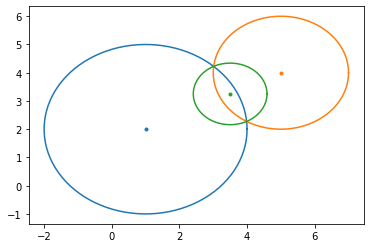

In [2]:
demo_Ba = (np.array([[1], [2]]), 3**2)
demo_Bb = (np.array([[5], [4]]), 2**2)

def get_b_enc(Ba, Bb):
    xa, r2a = Ba
    xb, r2b = Bb
    d = norm2(xb-xa)
    xoff = (r2a-r2b+d**2)/(2*d)
    return (xa+xoff*(xb-xa)/d, r2a-xoff**2)

def plot_2d_ball(x, r2, *args, **kwargs):
    t = np.linspace(0, 2*np.pi, 100)
    pts = x+np.sqrt(r2)*np.array([np.cos(t), np.sin(t)])
    line = plt.plot(*pts, *args, **kwargs)
    plt.plot(*x[:,0], ".", color=line[0].get_color())

plot_2d_ball(*demo_Ba)
plot_2d_ball(*demo_Bb)
plot_2d_ball(*get_b_enc(demo_Ba, demo_Bb))

Now, let's put this together with (3.16) from Bubeck to construct our algorithm…

In [3]:
def opposite_enclosing_ball(this_B):  # Can't figure out a good name for it -- this is the ball in (3.16)
    this_x, this_r2 = this_B
    return (get_x_plus_plus(this_x), norm2(grad_col(this_x))**2/max_alpha(this_x)**2 * (1-1/get_kappa(this_x)))

def get_next_b(this_B):
    opposite = opposite_enclosing_ball(this_B)
    return get_b_enc(this_B, opposite)

…and see if it works:

Terminating after 548 iterations as radius has gone negative
            x         y         z    radius     error
0    2.000000  3.000000  2.000000  4.000000  1.732051
27   1.023149  2.149082  0.982718  0.784915  0.151856
54   1.018375  2.004434  0.985828  0.639767  0.023625
81   1.014682  1.978512  0.988435  0.521200  0.028479
108  1.013335  2.008115  0.989430  0.476548  0.018852
135  1.012086  1.996604  0.990369  0.434468  0.015823
162  1.009674  1.999169  0.992214  0.348180  0.012446
189  1.008911  1.988869  0.992812  0.321679  0.015967
216  1.008597  2.011900  0.993059  0.310776  0.016238
243  1.004569  1.993525  0.996270  0.145472  0.008759
270  1.004440  2.006358  0.996375  0.141452  0.008560
297  1.004396  1.999848  0.996411  0.140040  0.005677
324  1.004229  1.998397  0.996547  0.134780  0.005690
351  1.003567  1.999091  0.997087  0.111902  0.004694
378  1.003516  1.999851  0.997129  0.110316  0.004542
405  1.003445  2.000634  0.997187  0.108148  0.004493
432  1.002851  2.0004

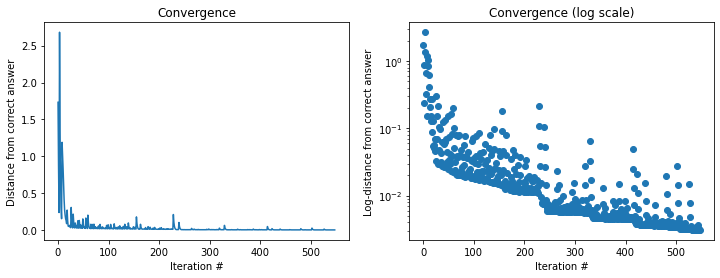

In [4]:
n_iters = 1000
this_b = B0
bs = []
opps = []

i = 1
while (i < n_iters):
    try:
        this_opp = opposite_enclosing_ball(this_b)
        bs.append(this_b)
        opps.append(this_opp)
        next_b = get_next_b(this_b)
        if next_b[1] > this_b[1]:
            print(f"Terminating after {i} iterations as radius is no longer decreasing")
            break
        if next_b[1] < 0:
            print(f"Terminating after {i} iterations as radius has gone negative")
            break
        this_b = next_b
        i += 1
    except Exception as e:
        print(f"Terminating after {i} iterations due to error '{e}'")
        break
if (i == n_iters): print(f"Terminating after {n_iters} iterations as planned")

centers = np.array([b[0] for b in bs])
radii = np.sqrt(np.array([b[1] for b in bs]))
errors = np.linalg.norm(centers-answer, axis=1)
results = np.concatenate([centers[:,:,0], radii.reshape((*radii.shape, 1)), errors], axis=-1)

try:  # If you have pandas, let's use it to print prettily
    import pandas as pd
    print(pd.DataFrame(results, columns=["x", "y", "z", "radius", "error"])[::max(1, i//20)])
except ModuleNotFoundError:  # Fallback
    print("i, x, y, z, radius, error:")
    ind = np.arange(i).reshape((*radii.shape, 1))
    print(np.concatenate([ind, results], axis=-1)[::max(1, i//20)])

# Line plot of the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(list(range(i)), errors)
axs[0].set_ylabel("Distance from correct answer")
axs[0].set_xlabel("Iteration #")
axs[0].set_title("Convergence")

# Scatter plot of the results with a logarithmic y-axis
axs[1].scatter(list(range(i)), errors)
axs[1].set_yscale("log")
axs[1].set_ylabel("Log-distance from correct answer")
axs[1].set_xlabel("Iteration #")
axs[1].set_title("Convergence (log scale)")
plt.show()